In [1]:
import os
import cv2
import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import utils
reload(utils)

from keras import backend as K
from keras.layers import Input
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Lambda
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
/home/lysuhin/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
def add_conv_block(model, nb_layer, nb_filter, convsize, activation, pool_size):
    for layer in range(nb_layer):
        model.add(ZeroPadding2D(padding = (convsize[0] / 2,convsize[1] / 2)))
        model.add(Convolution2D(nb_filter=nb_filter, nb_row=convsize[0], nb_col=convsize[1], activation=activation))
    model.add(MaxPooling2D(pool_size=pool_size, strides=pool_size))
    
def add_fc_block(model, output_dim, activation, p_drop):
    model.add(Dense(output_dim=output_dim, activation=activation))
    model.add(Dropout(p_drop))
    
def add_input_layer(model, func, input_shape, output_shape):
    model.add(Lambda(function=func, input_shape=input_shape, output_shape=output_shape))

In [3]:
def create_nn(output_dim=10, preproc=None):
    
    model = Sequential()
    if preproc is None:
        add_input_layer(model, lambda x:x+0, (3, 128, 128), (3, 128, 128))
    else:
        add_input_layer(model, func=preproc, input_shape=(3, 128, 128), output_shape=(3, 128, 128))
    add_conv_block(model, nb_layer=2, nb_filter=8, convsize=(5,5), activation="relu", pool_size=(2,2))
    add_conv_block(model, nb_layer=2, nb_filter=16, convsize=(5,5), activation="relu", pool_size=(5,5))
    add_conv_block(model, nb_layer=2, nb_filter=32, convsize=(5,5), activation="relu", pool_size=(5,5))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    add_fc_block(model, output_dim=512, activation="tanh", p_drop=0.20)
    add_fc_block(model, output_dim=512, activation="tanh", p_drop=0.15)
    add_fc_block(model, output_dim=512, activation="tanh", p_drop=0.10)
    # it's enough, man
    
    model.add(Dense(output_dim=output_dim, activation="softmax"))
    
    return model

In [4]:
def fit(model, batches, val_batches, nb_epoch=1):
        """
        Fits the model on data yielded batch-by-batch by a Python generator.
        See Keras documentation: https://keras.io/models/model/
        """
        model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
                            validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [5]:
def save_weights(model, train_loss, train_acc, val_loss, val_acc, path="../weights/", id_=123):
    path_to_save = path + "weights_{}".format(id_)
    model.save_weights(path_to_save)
    info = "{};{};{};{};{};\n".format(id_, train_loss, train_acc, val_loss, val_acc)    
    if os.path.isfile(path + "results.csv"):
        with open(path + "results.csv", "a") as f:
            f.write(info)
    print "saved to {}".format(path_to_save)

In [8]:
def get_data_mean(train_path):
    train_batches = utils.get_batches(train_path, target_size=(128, 128))
    mean = 0.
    
    for fname in tqdm.tqdm(train_batches.filenames):
        image = plt.imread(train_path+fname)
        mean += image.mean(axis=(0,1))
    mean /= len(train_batches.filenames)
    mean = mean.reshape(3, 1, 1)
    print mean
    return mean

###################################################################################################################

In [9]:
train_path = "../data/crops/train/"
test_path = "../data/crops/test/"

In [10]:
MEAN = get_data_mean(train_path=train_path)

  0%|          | 0/5989 [00:00<?, ?it/s]

Found 5989 images belonging to 17 classes.


100%|██████████| 5989/5989 [00:23<00:00, 251.21it/s]

[[[ 8.4947]]

 [[ 7.8407]]

 [[ 7.3567]]]


In [29]:
train_batches = utils.get_batches(train_path, batch_size=32, target_size=(128, 128))
test_batches = utils.get_batches(test_path, batch_size=32, target_size=(128, 128))

Found 5989 images belonging to 17 classes.
Found 1982 images belonging to 17 classes.


In [11]:
net = create_nn(output_dim=17, preproc=lambda x:x-MEAN)
net.compile(optimizer=Adam(0.01), loss="categorical_crossentropy", metrics=["accuracy"])
net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 128, 128)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 132, 132)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 8, 128, 128)   608         zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 8, 132, 132)   0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [ ]:
net.load_weights()

In [31]:
net.model.optimizer.lr.set_value(0.0005)
fit(net, train_batches, test_batches, nb_epoch=10)

Epoch 1/10
5989/5989 [==============================] - 29s - loss: 2.4112 - acc: 0.2386 - val_loss: 1.2021 - val_acc: 0.5671
Epoch 2/10
5989/5989 [==============================] - 29s - loss: 0.9576 - acc: 0.6696 - val_loss: 0.3914 - val_acc: 0.8799
Epoch 3/10
5989/5989 [==============================] - 29s - loss: 0.4771 - acc: 0.8415 - val_loss: 0.2513 - val_acc: 0.9243
Epoch 4/10
5989/5989 [==============================] - 29s - loss: 0.3043 - acc: 0.9080 - val_loss: 0.2006 - val_acc: 0.9425
Epoch 5/10
5989/5989 [==============================] - 29s - loss: 0.2318 - acc: 0.9277 - val_loss: 0.1544 - val_acc: 0.9526
Epoch 6/10
5989/5989 [==============================] - 28s - loss: 0.1793 - acc: 0.9417 - val_loss: 0.1374 - val_acc: 0.9606
Epoch 7/10
5989/5989 [==============================] - 29s - loss: 0.1676 - acc: 0.9421 - val_loss: 0.1144 - val_acc: 0.9627
Epoch 8/10
5989/5989 [==============================] - 29s - loss: 0.1427 - acc: 0.9554 - val_loss: 0.1087 - val_acc:

In [32]:
net.model.optimizer.lr.set_value(0.0001)
fit(net, train_batches, test_batches, nb_epoch=10)

Epoch 1/10
5989/5989 [==============================] - 29s - loss: 0.0640 - acc: 0.9785 - val_loss: 0.0845 - val_acc: 0.9773
Epoch 2/10
5989/5989 [==============================] - 29s - loss: 0.0444 - acc: 0.9858 - val_loss: 0.1068 - val_acc: 0.9692
Epoch 3/10
5989/5989 [==============================] - 29s - loss: 0.0404 - acc: 0.9876 - val_loss: 0.0785 - val_acc: 0.9768
Epoch 4/10
5989/5989 [==============================] - 29s - loss: 0.0344 - acc: 0.9898 - val_loss: 0.0701 - val_acc: 0.9793
Epoch 5/10
5989/5989 [==============================] - 29s - loss: 0.0354 - acc: 0.9888 - val_loss: 0.0884 - val_acc: 0.9783
Epoch 6/10
5989/5989 [==============================] - 29s - loss: 0.0295 - acc: 0.9905 - val_loss: 0.0751 - val_acc: 0.9828
Epoch 7/10
5989/5989 [==============================] - 29s - loss: 0.0262 - acc: 0.9925 - val_loss: 0.0687 - val_acc: 0.9808
Epoch 8/10
5989/5989 [==============================] - 29s - loss: 0.0315 - acc: 0.9908 - val_loss: 0.0789 - val_acc:

In [33]:
net.model.optimizer.lr.set_value(0.00005)
fit(net, train_batches, test_batches, nb_epoch=10)

Epoch 1/10
5989/5989 [==============================] - 29s - loss: 0.0243 - acc: 0.9928 - val_loss: 0.0775 - val_acc: 0.9798
Epoch 2/10
5989/5989 [==============================] - 29s - loss: 0.0204 - acc: 0.9942 - val_loss: 0.0791 - val_acc: 0.9813
Epoch 3/10
5989/5989 [==============================] - 29s - loss: 0.0197 - acc: 0.9948 - val_loss: 0.0567 - val_acc: 0.9823
Epoch 4/10
5989/5989 [==============================] - 28s - loss: 0.0265 - acc: 0.9913 - val_loss: 0.0727 - val_acc: 0.9778
Epoch 5/10
5989/5989 [==============================] - 29s - loss: 0.0151 - acc: 0.9957 - val_loss: 0.0642 - val_acc: 0.9834
Epoch 6/10
5989/5989 [==============================] - 29s - loss: 0.0183 - acc: 0.9945 - val_loss: 0.0613 - val_acc: 0.9818
Epoch 7/10
5989/5989 [==============================] - 29s - loss: 0.0153 - acc: 0.9957 - val_loss: 0.0726 - val_acc: 0.9793
Epoch 8/10
5989/5989 [==============================] - 29s - loss: 0.0146 - acc: 0.9953 - val_loss: 0.0897 - val_acc:

In [96]:
test_batches.batch_size

32

In [ ]:
utils.get_batches()

In [103]:
test_batches.

32

In [ ]:
te

In [134]:
def show_mistakes(test_batches, classnames_dict=None):
    ci = {}
    for key, value in test_batches.class_indices.items():
        ci.update({value: int(key)})
    total_mistakes = 0
    nb_batches = test_batches.n / test_batches.batch_size
    accuracy = 0.
    for j in range(nb_batches):
        images, labels_onehot = test_batches.next()
        predictions_onehot = net.predict_on_batch(images)
        true_labels = np.argmax(labels_onehot, axis=1)
        pred_labels = np.argmax(predictions_onehot, axis=1)
        wrong_ids = np.where(true_labels != pred_labels)[0]
        total_mistakes += len(wrong_ids)
        print("Test batch #{}:{} mistakes".format(j, len(wrong_ids)))
        if len(wrong_ids) > 0:
            wrong_images = images[wrong_ids]
            if classnames_dict is not None:
                titles = ["{} / {}".format(classnames_dict[ci[pred_labels[i]]], classnames_dict[ci[true_labels[i]]]) for i in wrong_ids]
            else:
                titles = ["{} / {}".format(pred_labels[i], true_labels[i]) for i in wrong_ids]
            utils.plots(wrong_images, figsize=(15, 4), titles=titles, fontsize=12)
            plt.show()
#         accuracy += len(wrong_ids) / test_batches.batch_size
    accuracy = 1. - (1. * total_mistakes / test_batches.n)
    print("Total mistakes: {}, accuracy: {}".format(total_mistakes, accuracy))
    return total_mistakes, accuracy

In [135]:
classnames_dict = {
    0: 'FIST-TOP',
    1: 'PALM-TOP',
    2: 'PALM-SIDE',
    3: 'RING',
    4: 'V',
    5: 'FIST-SIDE',
    6: 'THIRD-FINGER',
    7: 'GOAT',
    8: 'SECOND-FINGER',
    9: 'FOURTH-FINGER',
    10: 'DREI',
    11: 'POINTER',
    12: 'GOAT-INV',
    13: 'GUN',
    14: 'PALM-BOTTOM',
    15: 'FIRST-FINGER',
    16: 'FAN'
}

Test batch #0:0 mistakes
Test batch #1:1 mistakes


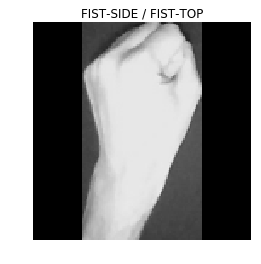

Test batch #2:0 mistakes
Test batch #3:1 mistakes


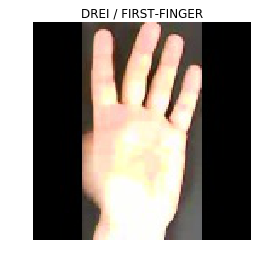

Test batch #4:0 mistakes
Test batch #5:0 mistakes
Test batch #6:0 mistakes
Test batch #7:2 mistakes


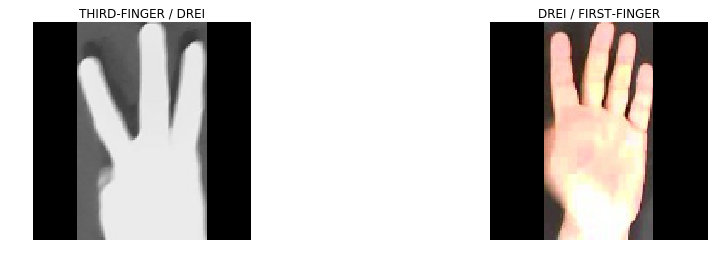

Test batch #8:1 mistakes


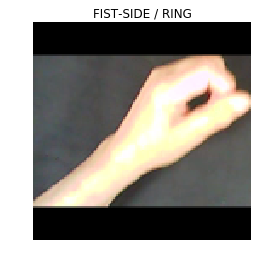

Test batch #9:2 mistakes


In [ ]:
show_mistakes(test_batches, classnames_dict=classnames_dict)

In [133]:
save_weights(net, 0.0145, 0.9960, 0.0622, 0.9823, id_=12)

saved to ../weights/weights_12
